
# Sex-biased tissues per cell line per perturbagen
--------------------------------------------------------------------------------
## Heatmap 3 features by sex: Female

###### 0 = no significant, no sex-bias tissue
###### 1 = significant, Tissue GTEX =/ Tissue Clue
###### 2 = significant, Tissue GTEX = Tissue Clue Sex-bias Female



Author: Belén Otero Carrasco

Last updated 07 December, 2023

#### Signatures selection news (exemplar = 1 and TAS higher)

--------------------------------------------------------------------------------

In [1]:
import pkg_resources
# Print version of cmapPy being used in current conda environment 
pkg_resources.get_distribution("cmapPy").version

'4.0.1'

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame
from cmapPy.pandasGEXpress.parse import parse
from scipy.stats import hypergeom
from tqdm import tqdm

C:\Users\Usuario\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


### Functions

In [3]:
def signatures_ids_perturbagen(drug):
    sig_pertu_ids = final_sig_original_filter["sig_id"][final_sig_original_filter["pert_iname"] == drug]
    print("number of samples treated with this perturbagen:")
    return sig_pertu_ids

In [4]:
def perturbagen_significant_genes(sig_pertu_ids,drug):
    perturbagen_genes_exp= parse("./Touchstone/GSE92742_Broad_LINCS_Level5_COMPZ.MODZ_n473647x12328.gctx", cid=sig_pertu_ids)
    df_perturbagen_genes_exp =perturbagen_genes_exp.data_df
    df_filter_significant = df_perturbagen_genes_exp[(df_perturbagen_genes_exp >2.0) | (df_perturbagen_genes_exp <-2.0)]
    df_bool_sign = df_filter_significant.notna()
    df_bool_sign["count"] = df_bool_sign.sum(axis=1)
    df_bool_sign = df_bool_sign.reset_index()
    df_gene_change = df_bool_sign[df_bool_sign["count"]> 0]
    df_gene_change_id = df_gene_change[["rid","count"]]
    df_gene_change_id["perturbagen_name"] = drug
    df_gene_change_id["Signature_id"] = sig_pertu_ids
    return df_gene_change_id 

In [5]:
def filter_by_tissue(tissue_type):
    data_gtex = pd.read_csv("signif.sbgenes.txt", sep="\t")
    filtered_df_tissue = data_gtex[data_gtex["tissue"] == tissue_type]
    return filtered_df_tissue

In [6]:
def filter_by_ids_and_tissue(tissue_type):
    data_total_genes_share = pd.read_csv("genes_hugo+ensembl.csv", sep=",")
    data_gtex_filter = data_gtex.merge(data_total_genes_share , on="gene")
    filtered_df_tissue_ids = data_gtex_filter[data_gtex_filter["tissue"] == tissue_type]
    return filtered_df_tissue_ids

In [7]:
def generate(disease_feature, diseases, features):
   
    """Function that from a list of relationships disease-feature obtains the
    feature matrix, so that rows are diseases and columns are features.
    """
   
   
    dis_feat_dict = { i : list() for i in diseases}
   
    disease_feature_array = disease_feature.to_numpy()
   
    for [disease, feature] in disease_feature_array:
       
        if not feature in dis_feat_dict[disease]:
            dis_feat_dict[disease].append(feature)
           
    bool_matr = [[0 for x in range(len(features))] for y in range(len(diseases))]
   
    count_dis = 0   
    for dis in diseases:       
        count_feat = 0       
        for feat in features:           
            if feat in dis_feat_dict[dis]:               
                bool_matr[count_dis][count_feat] = 1               
            count_feat += 1           
        count_dis += 1
   
    feature_matrix = pd.DataFrame(bool_matr)
    return feature_matrix

### Signature information

In [8]:
sig_cell_info = pd.read_excel(("new_signame_tas_exemplar.xlsx"),engine='openpyxl')
sig_cell_info.head()

cell_id base_cell_id sample_type primary_site  \
0    A375         A375       tumor         skin   
1    A375         A375       tumor         skin   
2    A375         A375       tumor         skin   
3    A375         A375       tumor         skin   
4    A375         A375       tumor         skin   

                            tissue   abrev             subtype  \
0  Skin_Not_Sun_Exposed_Suprapubic  SKINNS  malignant melanoma   
1  Skin_Not_Sun_Exposed_Suprapubic  SKINNS  malignant melanoma   
2  Skin_Not_Sun_Exposed_Suprapubic  SKINNS  malignant melanoma   
3  Skin_Not_Sun_Exposed_Suprapubic  SKINNS  malignant melanoma   
4  Skin_Not_Sun_Exposed_Suprapubic  SKINNS  malignant melanoma   

                                     sig_id                        pert_iname  \
0  CPC018_A375_6H:BRD-K06817181-001-01-5:10  1,2,3,4,5,6-hexabromocyclohexane   
1  CPC017_A375_6H:BRD-K74430258-001-01-2:10               1,2-dichlorobenzene   
2  CPC010_A375_6H:BRD-K32795028-001-10-9:10                 1-benzylimidazole   
3  CPC018_A375_6H:BRD-A80928489-001-01-0:10                    1-monopalmitin   
4  CPC018_A375_6H:BRD-K31491153-001-01-2:10                 1-phenylbiguanide   

        tas  is_exemplar                                Signature_id  
0  0.282354            1  1,2,3,4,5,6-hexabromocyclohexane_A375_skin  
1  0.057646            1               1,2-dichlorobenzene_A375_skin  
2  0.221885            1                 1-benzylimidazole_A375_skin  
3  0.118443            1                    1-monopalmitin_A375_skin  
4  0.313940            1                 1-phenylbiguanide_A375_skin

In [9]:
sig_pertu_ids = sig_cell_info["sig_id"][sig_cell_info["pert_iname"] == "tamoxifen"]

In [10]:
len(sig_pertu_ids.drop_duplicates())

56

In [11]:
sig_pertu_ids = sig_pertu_ids.drop_duplicates()

In [12]:
drugs_ids = sig_cell_info[["pert_iname"]].drop_duplicates()

In [13]:
drugs_ids = drugs_ids.values.ravel().tolist()

#### Gene (row) annotations 

In [14]:
gene_info = pd.read_csv("./GSE92742_Broad_LINCS_gene_info.txt", sep="\t", dtype=str)
gene_info.columns

Index(['pr_gene_id', 'pr_gene_symbol', 'pr_gene_title', 'pr_is_lm',
       'pr_is_bing'],
      dtype='object')

In [15]:
pertub_id = pd.read_csv("./GSE92742_Broad_LINCS_pert_info.txt", sep="\t", dtype=str)

In [16]:
per_metrics_id = pd.read_csv("./GSE92742_Broad_LINCS_pert_metrics.txt", sep="\t", dtype=str)
per_metrics_id = per_metrics_id.replace({"-666":"Unknown"})

In [17]:
data_total_genes_share = pd.read_csv("genes_hugo+ensembl.csv", sep=",")

In [18]:
data_gtex = pd.read_csv("signif.sbgenes.txt", sep="\t")

In [20]:
data_gtex['Sex-bias'] = data_gtex.apply(lambda row: 'Female' if row['effsize'] >= 0 else 'Male', axis=1)

In [22]:
pd.value_counts(data_gtex['Sex-bias'])

Sex-bias
Female    52851
Male      52013
Name: count, dtype: int64

In [24]:
data_gtex_tissues = data_gtex["tissue"].unique()

In [25]:
data_gtex_filter = data_gtex.merge(data_total_genes_share , on="gene")

In [28]:
data_gtex_filter

gene                    tissue    effsize  effsize_se  \
0      ENSG00000229807.10      Adipose_Subcutaneous   9.802124    0.071315   
1      ENSG00000229807.10  Adipose_Visceral_Omentum   9.942181    0.072492   
2      ENSG00000229807.10             Adrenal_Gland   9.565248    0.120011   
3      ENSG00000229807.10              Artery_Aorta  10.274669    0.095769   
4      ENSG00000229807.10           Artery_Coronary   9.680714    0.119024   
...                   ...                       ...        ...         ...   
62715   ENSG00000101132.9               Whole_Blood  -0.097052    0.048216   
62716   ENSG00000196812.4               Whole_Blood   0.057226    0.028974   
62717  ENSG00000111261.13               Whole_Blood  -0.043080    0.021107   
62718   ENSG00000163191.5               Whole_Blood   0.054503    0.026722   
62719  ENSG00000204610.12               Whole_Blood  -0.165408    0.082596   

           lfsr Sex-bias  Unnamed: 0  gene_id gene_symbol  
0      0.000000   Female           0     7503        XIST  
1      0.000000   Female           0     7503        XIST  
2      0.000000   Female           0     7503        XIST  
3      0.000000   Female           0     7503        XIST  
4      0.000000   Female           0     7503        XIST  
...         ...      ...         ...      ...         ...  
62715  0.019016     Male        7623     5203       PFDN4  
62716  0.019223   Female        7624    80345     ZSCAN16  
62717  0.021191     Male        7625    54682      MANSC1  
62718  0.024280   Female        7626     6282     S100A11  
62719  0.024650     Male        7627    89870      TRIM15  

[62720 rows x 9 columns]

In [29]:
pd.value_counts(data_gtex_filter['Sex-bias'])

Sex-bias
Female    32823
Male      29897
Name: count, dtype: int64

In [26]:
pd.options.mode.chained_assignment = None 

In [27]:
drugs_ids_check = ["tamoxifen"]

In [30]:
signatures_per_perturbagen = []
genes_significant_per_perturbagen = []
p_values_per_tissue_perturbagen = []
df = pd.DataFrame(columns=["Signature","Perturbagen_name","Tissue_type", "P-value" ])
overlap_genes = []

for drug in tqdm(drugs_ids_check):
    #print(drug)
    for num_sig, sig in enumerate(sig_pertu_ids): 
        #print (num_sig, sig)
        genes_significant = perturbagen_significant_genes(sig,drug)
        gene_info = pd.read_csv("./GSE92742_Broad_LINCS_gene_info.txt", sep="\t", dtype=str)
        genes_sig_per_pertur = genes_significant.merge(gene_info, left_on="rid", right_on="pr_gene_id")
        genes_sig_per_pertur = genes_sig_per_pertur[["perturbagen_name","Signature_id","pr_gene_id","pr_gene_symbol"]]
        genes_significant_per_perturbagen.append(genes_sig_per_pertur)

        for tissue in data_gtex_tissues:
            #print(tissue)
            tissue_type =filter_by_tissue(tissue)
            tissue_type_filter = filter_by_ids_and_tissue(tissue)
            overlap = genes_sig_per_pertur.merge(tissue_type_filter,left_on= "pr_gene_symbol",right_on="gene_symbol")
            overlap = overlap[["perturbagen_name","Signature_id","gene_symbol","tissue","Sex-bias"]]
            overlap_genes.append(overlap)

            # parameters
            population_total = 20000  #union Clue + gtex
            num_genes_change_expression_perturbagen = len(genes_sig_per_pertur)  # Number of genes clue significant
            num_genes_gtex_tissue = len(tissue_type) # GTEX tissue type n-genes
            overlap_len = len(overlap)  #overlap
            #test 
            #resultado = hypergeom.sf(overlap - 1, population_total, num_genes_change_expression_perturbagen, num_genes_gtex_tissue)
            result = hypergeom.sf(overlap_len - 1, population_total,num_genes_gtex_tissue,num_genes_change_expression_perturbagen)
            p_values_per_tissue_perturbagen.append(result)
            #print("P-value:", resultado, tissue, drug)
            row = pd.DataFrame({"P-value": [result], "Tissue_type": [tissue], "Perturbagen_name": [drug],"Signature":[sig]})
            df = pd.concat([df, row])
    
        
      
    

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [05:38<00:00, 338.02s/it]


In [37]:
len(df["Signature"].unique())

56

In [38]:
df

Signature Perturbagen_name  \
0   CPC005_A375_24H:BRD-K04210847-001-01-1:10        tamoxifen   
0   CPC005_A375_24H:BRD-K04210847-001-01-1:10        tamoxifen   
0   CPC005_A375_24H:BRD-K04210847-001-01-1:10        tamoxifen   
0   CPC005_A375_24H:BRD-K04210847-001-01-1:10        tamoxifen   
0   CPC005_A375_24H:BRD-K04210847-001-01-1:10        tamoxifen   
..                                        ...              ...   
0    CPC015_SKB_24H:BRD-K43744935-048-01-6:10        tamoxifen   
0    CPC015_SKB_24H:BRD-K43744935-048-01-6:10        tamoxifen   
0    CPC015_SKB_24H:BRD-K43744935-048-01-6:10        tamoxifen   
0    CPC015_SKB_24H:BRD-K43744935-048-01-6:10        tamoxifen   
0    CPC015_SKB_24H:BRD-K43744935-048-01-6:10        tamoxifen   

                       Tissue_type   P-value  
0             Adipose_Subcutaneous  0.288210  
0         Adipose_Visceral_Omentum  0.466375  
0                    Adrenal_Gland  0.579258  
0                     Artery_Aorta  0.934469  
0                  Artery_Coronary  0.872566  
..                             ...       ...  
0   Small_Intestine_Terminal_Ileum  0.774316  
0                           Spleen  0.568827  
0                          Stomach  0.729772  
0                          Thyroid  0.962904  
0                      Whole_Blood  0.917084  

[2464 rows x 4 columns]

In [39]:
df_all

perturbagen_name                               Signature_id gene_symbol  \
0            tamoxifen  CPC005_A375_24H:BRD-K04210847-001-01-1:10      SQSTM1   
1            tamoxifen  CPC005_A375_24H:BRD-K04210847-001-01-1:10       HMGA2   
2            tamoxifen  CPC005_A375_24H:BRD-K04210847-001-01-1:10     IGF2BP2   
3            tamoxifen  CPC005_A375_24H:BRD-K04210847-001-01-1:10       CCNB1   
4            tamoxifen  CPC005_A375_24H:BRD-K04210847-001-01-1:10     SUV39H1   
...                ...                                        ...         ...   
76136        tamoxifen   CPC015_SKB_24H:BRD-K43744935-048-01-6:10        RBP4   
76137        tamoxifen   CPC015_SKB_24H:BRD-K43744935-048-01-6:10       COPZ2   
76138        tamoxifen   CPC015_SKB_24H:BRD-K43744935-048-01-6:10       RAP2A   
76139        tamoxifen   CPC015_SKB_24H:BRD-K43744935-048-01-6:10       PTGDS   
76140        tamoxifen   CPC015_SKB_24H:BRD-K43744935-048-01-6:10     ZSCAN16   

                     tissue Sex-bias  
0      Adipose_Subcutaneous     Male  
1      Adipose_Subcutaneous   Female  
2      Adipose_Subcutaneous   Female  
3      Adipose_Subcutaneous   Female  
4      Adipose_Subcutaneous   Female  
...                     ...      ...  
76136           Whole_Blood   Female  
76137           Whole_Blood   Female  
76138           Whole_Blood     Male  
76139           Whole_Blood     Male  
76140           Whole_Blood   Female  

[76141 rows x 5 columns]

In [42]:
test_tissue = df_all[
    (df_all.Signature_id == "CPC005_A375_24H:BRD-K04210847-001-01-1:10") &
    (df_all.tissue == "Adipose_Subcutaneous") ]
test_tissue

perturbagen_name                               Signature_id gene_symbol  \
0         tamoxifen  CPC005_A375_24H:BRD-K04210847-001-01-1:10      SQSTM1   
1         tamoxifen  CPC005_A375_24H:BRD-K04210847-001-01-1:10       HMGA2   
2         tamoxifen  CPC005_A375_24H:BRD-K04210847-001-01-1:10     IGF2BP2   
3         tamoxifen  CPC005_A375_24H:BRD-K04210847-001-01-1:10       CCNB1   
4         tamoxifen  CPC005_A375_24H:BRD-K04210847-001-01-1:10     SUV39H1   
..              ...                                        ...         ...   
70        tamoxifen  CPC005_A375_24H:BRD-K04210847-001-01-1:10        E2F1   
71        tamoxifen  CPC005_A375_24H:BRD-K04210847-001-01-1:10       THBS2   
72        tamoxifen  CPC005_A375_24H:BRD-K04210847-001-01-1:10      ACOT11   
73        tamoxifen  CPC005_A375_24H:BRD-K04210847-001-01-1:10       DIDO1   
74        tamoxifen  CPC005_A375_24H:BRD-K04210847-001-01-1:10     TMEM144   

                  tissue Sex-bias  
0   Adipose_Subcutaneous     Male  
1   Adipose_Subcutaneous   Female  
2   Adipose_Subcutaneous   Female  
3   Adipose_Subcutaneous   Female  
4   Adipose_Subcutaneous   Female  
..                   ...      ...  
70  Adipose_Subcutaneous   Female  
71  Adipose_Subcutaneous     Male  
72  Adipose_Subcutaneous   Female  
73  Adipose_Subcutaneous     Male  
74  Adipose_Subcutaneous   Female  

[75 rows x 5 columns]

In [43]:
 pd.value_counts(test_tissue["Sex-bias"])

Sex-bias
Male      39
Female    36
Name: count, dtype: int64

In [ ]:
### There are 75 overlap genes between gtex and clue but, 
### What is the way of sex-bias in these case? Male or Female? 
### There are 39 genes with sex bias male and 36 genes with sex bias female in this tissue
### maybe the higher? male?

In [ ]:
### the idea is create a heatmap with 4 colors 
#Heatmap 4 features
#0 = no significant, no sex-bias tissue (beige)
#1 = significant, Tissue GTEX =/ Tissue Clue (light green)
#2 = significant, Tissue GTEX = Tissue Clue Sex-bias Male (dark green)
#3 = significant, Tissue GTEX = Tissue Clue Sex-bias Female (dark purple)

In [ ]:
### other idea is create a heatmap with 5 colors 
#Heatmap 4 features
#0 = no significant, no sex-bias tissue (beige)
#1 = significant, Tissue GTEX =/ Tissue Clue Sex-bias Male (light green)
#2 = significant, Tissue GTEX =/ Tissue Clue Sex-bias Female (light purple)
#3 = significant, Tissue GTEX = Tissue Clue Sex-bias Male (dark green)
#4 = significant, Tissue GTEX = Tissue Clue Sex-bias Female (dark purple)

In [99]:
abrev_tissue = pd.read_excel(("mapping_tissues_GTEX_CLUE.xlsx"),engine='openpyxl')

In [112]:
mapping = df.merge(abrev_tissue, left_on=["Tissue_type"],right_on=["tissue"])

In [114]:
mapping = mapping[["Signature","Perturbagen_name","Tissue_type","P-value","primary_site"]]

In [104]:
info_tissue_cell = sig_cell_info[["sig_id","Signature_id","cell_id","primary_site"]]
info_tissue_cell = info_tissue_cell.drop_duplicates()
info_tissue_cell

sig_id  \
0       CPC018_A375_6H:BRD-K06817181-001-01-5:10   
1       CPC017_A375_6H:BRD-K74430258-001-01-2:10   
2       CPC010_A375_6H:BRD-K32795028-001-10-9:10   
3       CPC018_A375_6H:BRD-A80928489-001-01-0:10   
4       CPC018_A375_6H:BRD-K31491153-001-01-2:10   
...                                          ...   
258599        KDB008_SKL_96H:TRCN0000020197:-666   
258600        KDB002_SKL_96H:TRCN0000236645:-666   
258601        KDB001_SKL_96H:TRCN0000150938:-666   
258602        KDB007_SKL_96H:TRCN0000072242:-666   
258603        KDB008_SKL_96H:TRCN0000145620:-666   

                                      Signature_id cell_id primary_site  
0       1,2,3,4,5,6-hexabromocyclohexane_A375_skin    A375         skin  
1                    1,2-dichlorobenzene_A375_skin    A375         skin  
2                      1-benzylimidazole_A375_skin    A375         skin  
3                         1-monopalmitin_A375_skin    A375         skin  
4                      1-phenylbiguanide_A375_skin    A375         skin  
...                                            ...     ...          ...  
258599                           ZNF589_SKL_muscle     SKL       muscle  
258600                           ZNF629_SKL_muscle     SKL       muscle  
258601                             ZW10_SKL_muscle     SKL       muscle  
258602                             lacZ_SKL_muscle     SKL       muscle  
258603                              pgw_SKL_muscle     SKL       muscle  

[173142 rows x 4 columns]

In [105]:
#info_tissue_cell = sig_cell_info[["sig_id","Signature_id","cell_id","primary_site","tissue","subtype"]]
#info_tissue_cell = info_tissue_cell.drop_duplicates()
#info_tissue_cell

In [115]:
clue_tiss_sig_gtex_ = mapping.merge(info_tissue_cell, left_on=["Signature"],right_on=["sig_id"])

In [117]:
clue_tiss_sig_gtex_['Significant'] = clue_tiss_sig_gtex_.apply(lambda row: 'No' if row['P-value'] > 0.05 else 'Yes', axis=1)

In [119]:
clue_tiss_sig_gtex_['Equal tissue']  = clue_tiss_sig_gtex_.apply(lambda x: str(x.primary_site_x) in str(x.primary_site_y), axis=1)

In [40]:
#clue_tiss_sig_gtex['Significant'] = clue_tiss_sig_gtex.apply(lambda row: 'No' if row['P-value'] > 0.05 else 'Yes', axis=1)

In [26]:
#df['Heatmap_values'] = df.apply(lambda row: 0 if row['Significant'] = "No" else 1, axis=1)

In [147]:
clue_tiss_sig_gtex_['Heatmap_values'] = np.where(
    (clue_tiss_sig_gtex_["Significant"] == "Yes") & (clue_tiss_sig_gtex_["Equal tissue"] == True), 2,
    np.where(
        (clue_tiss_sig_gtex_["Significant"] == "Yes") & (clue_tiss_sig_gtex_["Equal tissue"] == False), 1, 0))
clue_tiss_sig_gtex_

Signature Perturbagen_name  \
0     CPC005_A375_24H:BRD-K04210847-001-01-1:10        tamoxifen   
1     CPC005_A375_24H:BRD-K04210847-001-01-1:10        tamoxifen   
2     CPC005_A375_24H:BRD-K04210847-001-01-1:10        tamoxifen   
3     CPC005_A375_24H:BRD-K04210847-001-01-1:10        tamoxifen   
4     CPC005_A375_24H:BRD-K04210847-001-01-1:10        tamoxifen   
...                                         ...              ...   
2459   CPC015_SKB_24H:BRD-K43744935-048-01-6:10        tamoxifen   
2460   CPC015_SKB_24H:BRD-K43744935-048-01-6:10        tamoxifen   
2461   CPC015_SKB_24H:BRD-K43744935-048-01-6:10        tamoxifen   
2462   CPC015_SKB_24H:BRD-K43744935-048-01-6:10        tamoxifen   
2463   CPC015_SKB_24H:BRD-K43744935-048-01-6:10        tamoxifen   

                         Tissue_type   P-value   primary_site_x  \
0               Adipose_Subcutaneous  0.288210          adipose   
1           Adipose_Visceral_Omentum  0.466375          adipose   
2                      Adrenal_Gland  0.579258          Unknown   
3                       Artery_Aorta  0.934469  vascular system   
4                    Artery_Coronary  0.872566  vascular system   
...                              ...       ...              ...   
2459  Small_Intestine_Terminal_Ileum  0.774316          Unknown   
2460                          Spleen  0.568827          Unknown   
2461                         Stomach  0.729772          stomach   
2462                         Thyroid  0.962904          Unknown   
2463                     Whole_Blood  0.917084            blood   

                                         sig_id          Signature_id cell_id  \
0     CPC005_A375_24H:BRD-K04210847-001-01-1:10   tamoxifen_A375_skin    A375   
1     CPC005_A375_24H:BRD-K04210847-001-01-1:10   tamoxifen_A375_skin    A375   
2     CPC005_A375_24H:BRD-K04210847-001-01-1:10   tamoxifen_A375_skin    A375   
3     CPC005_A375_24H:BRD-K04210847-001-01-1:10   tamoxifen_A375_skin    A375   
4     CPC005_A375_24H:BRD-K04210847-001-01-1:10   tamoxifen_A375_skin    A375   
...                                         ...                   ...     ...   
2459   CPC015_SKB_24H:BRD-K43744935-048-01-6:10  tamoxifen_SKB_muscle     SKB   
2460   CPC015_SKB_24H:BRD-K43744935-048-01-6:10  tamoxifen_SKB_muscle     SKB   
2461   CPC015_SKB_24H:BRD-K43744935-048-01-6:10  tamoxifen_SKB_muscle     SKB   
2462   CPC015_SKB_24H:BRD-K43744935-048-01-6:10  tamoxifen_SKB_muscle     SKB   
2463   CPC015_SKB_24H:BRD-K43744935-048-01-6:10  tamoxifen_SKB_muscle     SKB   

     primary_site_y Significant  Equal tissue  Heatmap_values  
0              skin          No         False               0  
1              skin          No         False               0  
2              skin          No         False               0  
3              skin          No         False               0  
4              skin          No         False               0  
...             ...         ...           ...             ...  
2459         muscle          No         False               0  
2460         muscle          No         False               0  
2461         muscle          No         False               0  
2462         muscle          No         False               0  
2463         muscle          No         False               0  

[2464 rows x 12 columns]

In [149]:
#clue_tiss_sig_gtex[clue_tiss_sig_gtex["Significant"]=="Yes"]

In [150]:
clue_tiss_sig_gtex_pivot = clue_tiss_sig_gtex_[["Signature_id","Tissue_type", "Heatmap_values"]]

In [64]:
#clue_tiss_sig_gtex_pivot = clue_tiss_sig_gtex_pivot.drop_duplicates()

In [127]:
#len(clue_tiss_sig_gtex_pivot["Signature_id"].unique())

In [126]:
#clue_tiss_sig_gtex_pivot.drop_duplicates(subset=["Signature_id", "Tissue_type"])
#clue_tiss_sig_gtex_pivot.groupby(by=["Signature_id", "Tissue_type"])["Heatmap_values"].sum().reset_index().sort_values(by=["Heatmap_values"])

In [151]:
group_dis = clue_tiss_sig_gtex_pivot.pivot(index='Signature_id', columns='Tissue_type', values='Heatmap_values')

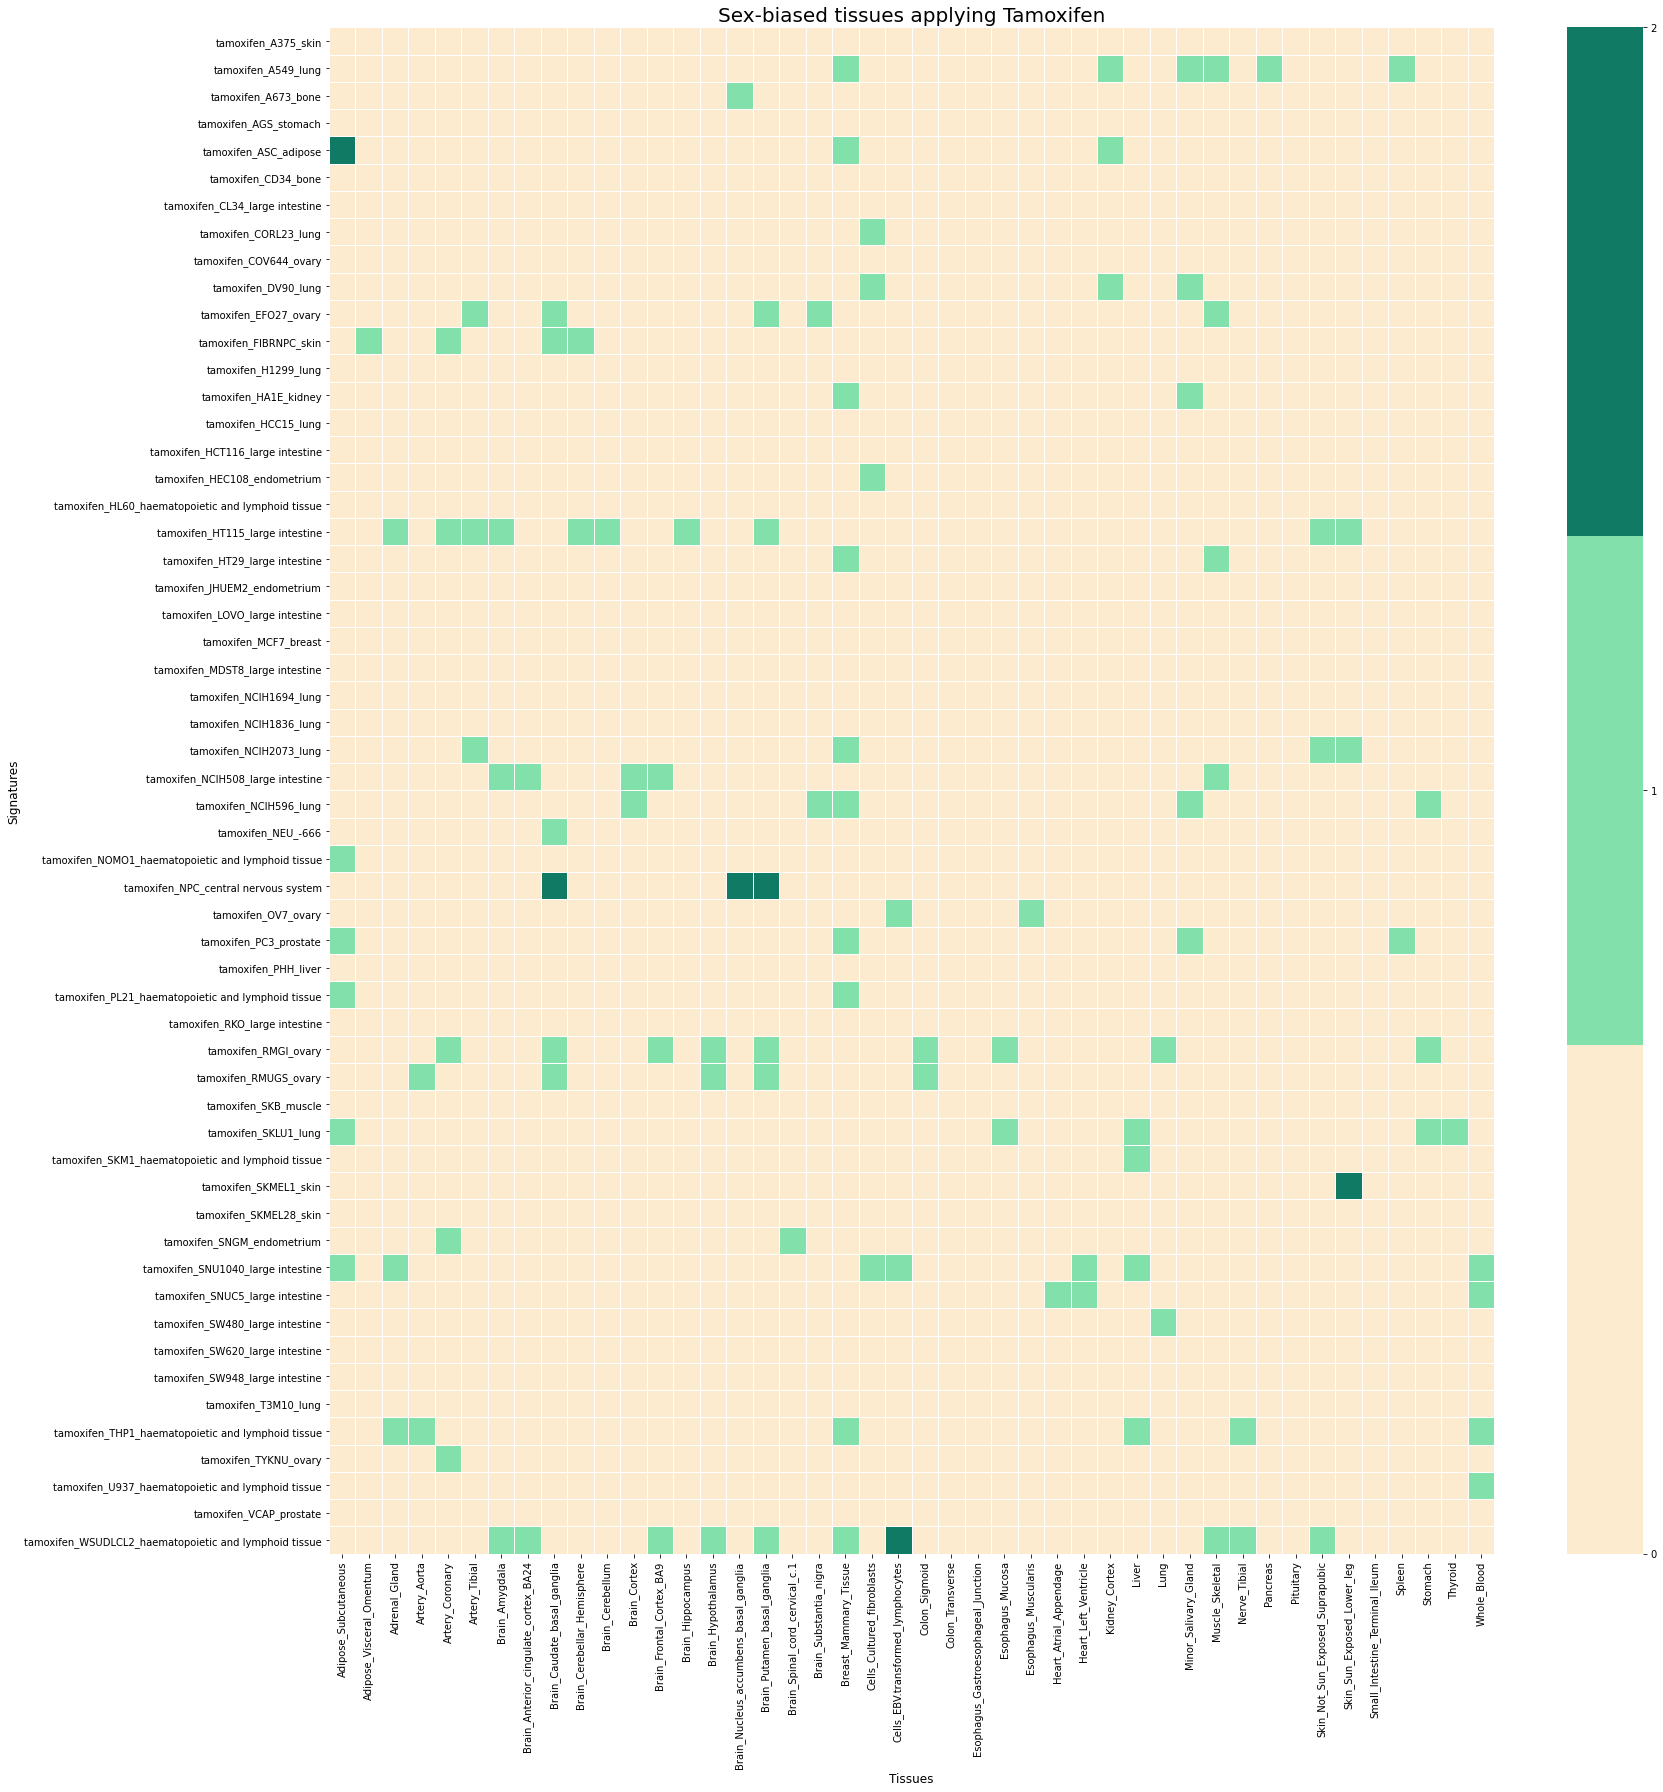

In [175]:
#cmap = plt.get_cmap('RdYlBu', 3)
fig, ax = plt.subplots(figsize=(25, 25))
ax = sns.heatmap(group_dis,linewidth=.5,cmap= ["#FDEBD0","#82E0AA","#117A65"],vmin=0, vmax=2)#PiYG
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([0, 1, 2])
plt.title('Sex-biased tissues applying Tamoxifen', fontsize = 20) # title with fontsize 20
plt.xlabel('Tissues', fontsize = 12) # x-axis label with fontsize 15
plt.ylabel('Signatures', fontsize = 12) # y-axis label with fontsize 15
plt.tight_layout()
#plt.savefig("cell_line_tamoxifen_signatures_results.svg")
plt.show()

In [28]:
result = df.groupby(['Significant','Signature']).count()

In [29]:
result = result.reset_index()

In [30]:
result = result[["Significant","Signature","Tissue_type"]]

In [65]:
pivot = pd.pivot_table(data=result, index=['Signature'], columns=['Significant'], values='Tissue_type')

In [66]:
pivot = pivot.fillna(0)

In [70]:
pivot_table = pivot.sort_index(axis=1,ascending=False)

In [108]:
pivot_table_sort = pivot_table.sort_values(by='Yes',ascending=False)

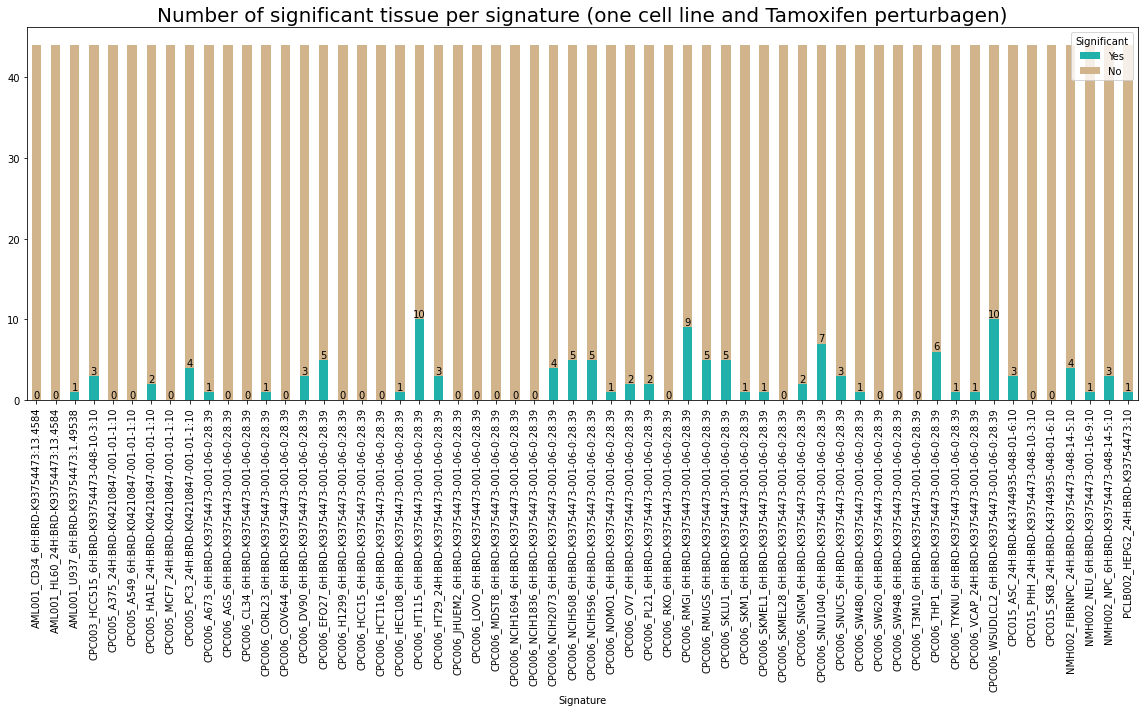

In [105]:
#fig, ax = plt.subplots(figsize=(16, 10))
ax = pivot_table.plot.bar(stacked=True, color =['lightseagreen','tan'],figsize=(16, 10))#,#order_by= pivot_table["Yes"] )
plt.title('Number of significant tissue per signature (one cell line and Tamoxifen perturbagen)', fontsize = 20) # title with fontsize 20
plt.bar_label(ax.containers[0])
#plt.xlabel('Tissues', fontsize = 12) # x-axis label with fontsize 15
#plt.ylabel('Signatures', fontsize = 12) # y-axis label with fontsize 15
plt.tight_layout()
plt.savefig("Number_of_sig_tissue_cell_line_tamoxifen.svg")
plt.show()

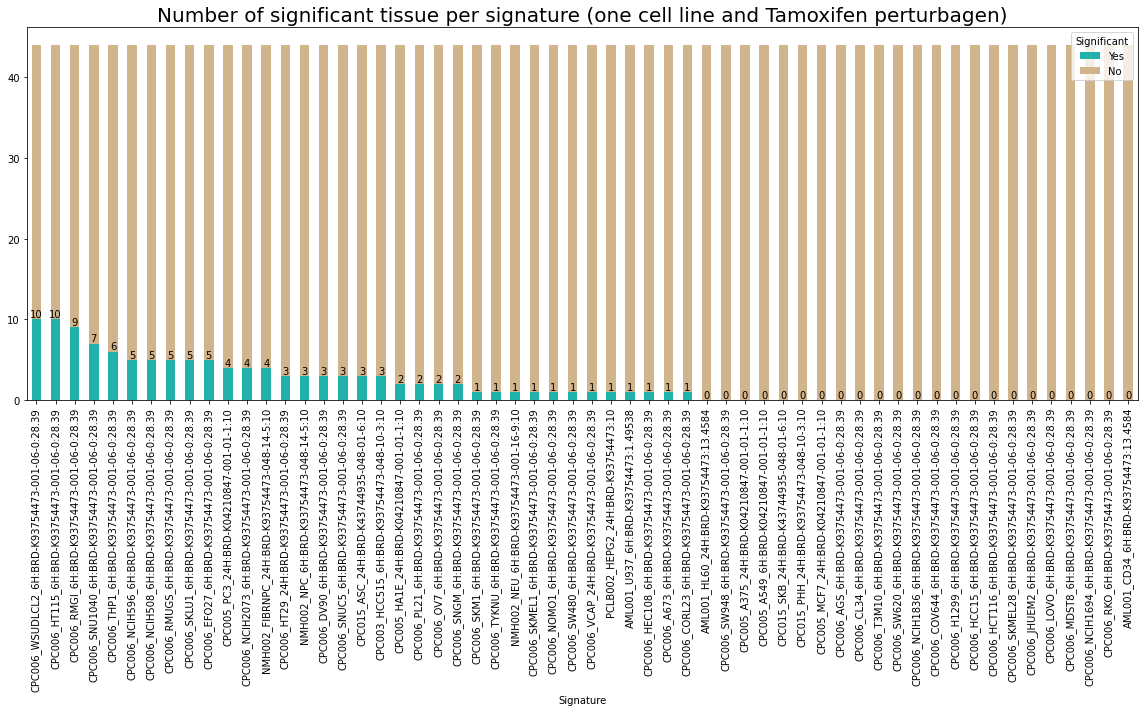

In [109]:
#fig, ax = plt.subplots(figsize=(16, 10))
ax = pivot_table_sort.plot.bar(stacked=True, color =['lightseagreen','tan'],figsize=(16, 10))
plt.title('Number of significant tissue per signature (one cell line and Tamoxifen perturbagen)', fontsize = 20) # title with fontsize 20
plt.bar_label(ax.containers[0])
#plt.xlabel('Tissues', fontsize = 12) # x-axis label with fontsize 15
#plt.ylabel('Signatures', fontsize = 12) # y-axis label with fontsize 15
plt.tight_layout()
#plt.savefig("Number_of_sig_tissue_cell_line_tamoxifen.svg")
plt.show()

In [93]:
len(df["Signature"].unique())

58

In [95]:
info_tissue_cell

sig_id cell_id primary_site  \
0       CPC018_A375_6H:BRD-K06817181-001-01-5:10    A375         skin   
1       CPC017_A375_6H:BRD-K74430258-001-01-2:10    A375         skin   
2       CPC010_A375_6H:BRD-K32795028-001-10-9:10    A375         skin   
3       CPC018_A375_6H:BRD-A80928489-001-01-0:10    A375         skin   
4       CPC018_A375_6H:BRD-K31491153-001-01-2:10    A375         skin   
...                                          ...     ...          ...   
264162        KDB008_SKL_96H:TRCN0000020197:-666     SKL       muscle   
264163        KDB002_SKL_96H:TRCN0000236645:-666     SKL       muscle   
264164        KDB001_SKL_96H:TRCN0000150938:-666     SKL       muscle   
264165        KDB007_SKL_96H:TRCN0000072242:-666     SKL       muscle   
264166        KDB008_SKL_96H:TRCN0000145620:-666     SKL       muscle   

                                 tissue                               subtype  
0       Skin_Not_Sun_Exposed_Suprapubic                    malignant melanoma  
1       Skin_Not_Sun_Exposed_Suprapubic                    malignant melanoma  
2       Skin_Not_Sun_Exposed_Suprapubic                    malignant melanoma  
3       Skin_Not_Sun_Exposed_Suprapubic                    malignant melanoma  
4       Skin_Not_Sun_Exposed_Suprapubic                    malignant melanoma  
...                                 ...                                   ...  
264162                  Muscle_Skeletal  normal primary skeletal muscle cells  
264163                  Muscle_Skeletal  normal primary skeletal muscle cells  
264164                  Muscle_Skeletal  normal primary skeletal muscle cells  
264165                  Muscle_Skeletal  normal primary skeletal muscle cells  
264166                  Muscle_Skeletal  normal primary skeletal muscle cells  

[264167 rows x 5 columns]

In [96]:
clue_tiss_sig_gtex = df.merge(info_tissue_cell, left_on="Signature",right_on="sig_id")

In [ ]:
## join df with info cell line
## then, selected only the significant registers in df

In [97]:
clue_tiss_sig_gtex_sig  = clue_tiss_sig_gtex[clue_tiss_sig_gtex["Significant"]=="Yes"]

In [98]:
clue_tiss_sig_gtex_sig['Significance equal tissue']  = clue_tiss_sig_gtex_sig.apply(lambda x: str(x.Tissue_type) in str(x.tissue), axis=1)

In [99]:
clue_tiss_sig_gtex_sig

Signature Perturbagen_name  \
147     CPC006_A673_6H:BRD-K93754473-001-06-0:28.39        tamoxifen   
284   CPC006_CORL23_6H:BRD-K93754473-001-06-0:28.39        tamoxifen   
372     CPC006_DV90_6H:BRD-K93754473-001-06-0:28.39        tamoxifen   
381     CPC006_DV90_6H:BRD-K93754473-001-06-0:28.39        tamoxifen   
384     CPC006_DV90_6H:BRD-K93754473-001-06-0:28.39        tamoxifen   
...                                             ...              ...   
3125       CPC015_ASC_24H:BRD-K43744935-048-01-6:10        tamoxifen   
3162       CPC015_ASC_24H:BRD-K43744935-048-01-6:10        tamoxifen   
3163       CPC015_ASC_24H:BRD-K43744935-048-01-6:10        tamoxifen   
3182       CPC015_ASC_24H:BRD-K43744935-048-01-6:10        tamoxifen   
3183       CPC015_ASC_24H:BRD-K43744935-048-01-6:10        tamoxifen   

                                Tissue_type   P-value Significant  \
147   Brain_Nucleus_accumbens_basal_ganglia  0.027830         Yes   
284              Cells_Cultured_fibroblasts  0.035913         Yes   
372              Cells_Cultured_fibroblasts  0.027632         Yes   
381                           Kidney_Cortex  0.048627         Yes   
384                    Minor_Salivary_Gland  0.009112         Yes   
...                                     ...       ...         ...   
3125                   Adipose_Subcutaneous  0.039366         Yes   
3162                  Breast_Mammary_Tissue  0.005854         Yes   
3163                  Breast_Mammary_Tissue  0.005854         Yes   
3182                          Kidney_Cortex  0.041273         Yes   
3183                          Kidney_Cortex  0.041273         Yes   

      Significant_                                         sig_id cell_id  \
147              1    CPC006_A673_6H:BRD-K93754473-001-06-0:28.39    A673   
284              1  CPC006_CORL23_6H:BRD-K93754473-001-06-0:28.39  CORL23   
372              1    CPC006_DV90_6H:BRD-K93754473-001-06-0:28.39    DV90   
381              1    CPC006_DV90_6H:BRD-K93754473-001-06-0:28.39    DV90   
384              1    CPC006_DV90_6H:BRD-K93754473-001-06-0:28.39    DV90   
...            ...                                            ...     ...   
3125             1       CPC015_ASC_24H:BRD-K43744935-048-01-6:10     ASC   
3162             1       CPC015_ASC_24H:BRD-K43744935-048-01-6:10     ASC   
3163             1       CPC015_ASC_24H:BRD-K43744935-048-01-6:10     ASC   
3182             1       CPC015_ASC_24H:BRD-K43744935-048-01-6:10     ASC   
3183             1       CPC015_ASC_24H:BRD-K43744935-048-01-6:10     ASC   

     primary_site                    tissue  \
147          bone                       NaN   
284          lung                      Lung   
372          lung                      Lung   
381          lung                      Lung   
384          lung                      Lung   
...           ...                       ...   
3125      adipose  Adipose_Visceral_Omentum   
3162      adipose      Adipose_Subcutaneous   
3163      adipose  Adipose_Visceral_Omentum   
3182      adipose      Adipose_Subcutaneous   
3183      adipose  Adipose_Visceral_Omentum   

                                               subtype  \
147                                    ewing's sarcoma   
284   non small cell lung cancer| large cell carcinoma   
372         non small cell lung cancer| adenocarcinoma   
381         non small cell lung cancer| adenocarcinoma   
384         non small cell lung cancer| adenocarcinoma   
...                                                ...   
3125               normal primary adipocyte stem cells   
3162               normal primary adipocyte stem cells   
3163               normal primary adipocyte stem cells   
3182               normal primary adipocyte stem cells   
3183               normal primary adipocyte stem cells   

      Significance equal tissue  
147                       False  
284                       False  
372                       False  
381                      

In [106]:
clue_tiss_sig_gtex_sig[clue_tiss_sig_gtex_sig["Significance equal tissue"]== True]

Signature Perturbagen_name  \
1749    CPC006_SKMEL1_6H:BRD-K93754473-001-06-0:28.39        tamoxifen   
2353  CPC006_WSUDLCL2_6H:BRD-K93754473-001-06-0:28.39        tamoxifen   
2534          NMH002_NPC_6H:BRD-K93754473-048-14-5:10        tamoxifen   
2639          NMH002_NPC_6H:BRD-K93754473-048-14-5:10        tamoxifen   
2654          NMH002_NPC_6H:BRD-K93754473-048-14-5:10        tamoxifen   
3124         CPC015_ASC_24H:BRD-K43744935-048-01-6:10        tamoxifen   

                                Tissue_type   P-value Significant  \
1749             Skin_Sun_Exposed_Lower_leg  0.045031         Yes   
2353      Cells_EBV.transformed_lymphocytes  0.017128         Yes   
2534            Brain_Caudate_basal_ganglia  0.020288         Yes   
2639  Brain_Nucleus_accumbens_basal_ganglia  0.014830         Yes   
2654            Brain_Putamen_basal_ganglia  0.005646         Yes   
3124                   Adipose_Subcutaneous  0.039366         Yes   

      Significant_                                           sig_id   cell_id  \
1749             1    CPC006_SKMEL1_6H:BRD-K93754473-001-06-0:28.39    SKMEL1   
2353             1  CPC006_WSUDLCL2_6H:BRD-K93754473-001-06-0:28.39  WSUDLCL2   
2534             1          NMH002_NPC_6H:BRD-K93754473-048-14-5:10       NPC   
2639             1          NMH002_NPC_6H:BRD-K93754473-048-14-5:10       NPC   
2654             1          NMH002_NPC_6H:BRD-K93754473-048-14-5:10       NPC   
3124             1         CPC015_ASC_24H:BRD-K43744935-048-01-6:10       ASC   

                            primary_site  \
1749                                skin   
2353  haematopoietic and lymphoid tissue   
2534              central nervous system   
2639              central nervous system   
2654              central nervous system   
3124                             adipose   

                                     tissue  \
1749             Skin_Sun_Exposed_Lower_leg   
2353      Cells_EBV.transformed_lymphocytes   
2534            Brain_Caudate_basal_ganglia   
2639  Brain_Nucleus_accumbens_basal_ganglia   
2654            Brain_Putamen_basal_ganglia   
3124                   Adipose_Subcutaneous   

                                                subtype  \
1749                                 malignant melanoma   
2353  lymphoma| B-cell| non-hodgkin's| diffuse large...   
2534               normal stem fibroblast-derived iPScs   
2639               normal stem fibroblast-derived iPScs   
2654               normal stem fibroblast-derived iPScs   
3124                normal primary adipocyte stem cells   

      Significance equal tissue  
1749                       True  
2353                       True  
2534                       True  
2639                       True  
2654                       True  
3124                       True

In [ ]:
## 6 cases where GTEX tissue = CLUE  tissue primary site 

In [118]:
count_tissue_df= count_tissue_df.reset_index()
count_tissue_df = count_tissue_df[["Tissue_type", "count"]]

In [119]:
abrev_tissue = pd.read_excel(("abrev_tissue.xlsx"),engine='openpyxl')
abrev_tissue.head()

tissue    abrev
0      Adipose_Subcutaneous   ADPSBQ
1  Adipose_Visceral_Omentum   ADPVSC
2             Adrenal_Gland   ADRNLG
3              Artery_Aorta  ARTAORT
4           Artery_Coronary   ARTCRN

In [120]:
abrev_tissu_all_data = abrev_tissue.merge(count_tissue_df,left_on="tissue",right_on="Tissue_type")

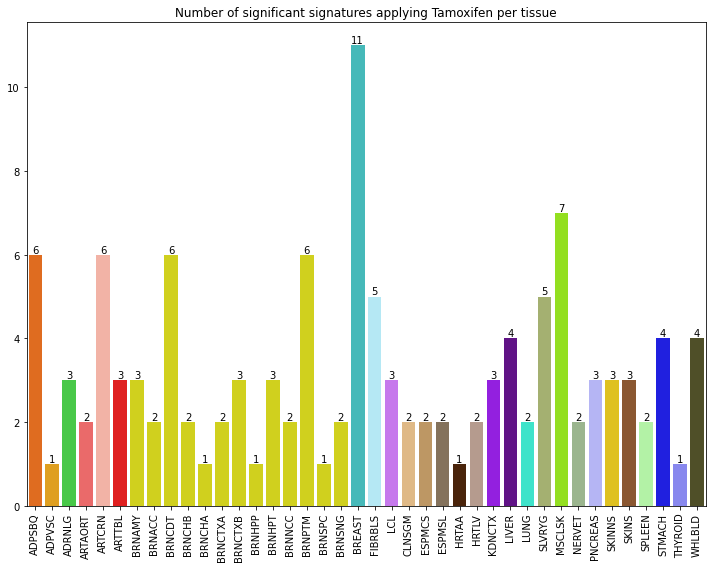

In [163]:
fig, ax = plt.subplots(figsize=(10, 8))
my_colors = ["#FF6600","#FFAA00","#33DD33","#FF5555","#FFAA99","#FF0000","#EEEE00","#EEEE00","#EEEE00","#EEEE00","#EEEE00",
             "#EEEE00","#EEEE00","#EEEE00","#EEEE00","#EEEE00","#EEEE00","#EEEE00","#EEEE00","#33CCCC","#AAEEFF","#CC66FF",
             "#EEBB77","#CC9955","#8B7355","#552200","#BB9988","#9900FF","#660099","#22FFDD","#AABB66","#99FF00","#99BB88",
             "#AAAAFF","#FFD700","#995522","#AAFF99","#0000FF","#7777FF","#555522","#778855","#FFDD99","#006600","#FF00BB"] 
sns.set_palette( my_colors )
sns.barplot(data=abrev_tissu_all_data, x="abrev", y="count",orient='v').set_title('Number of significant signatures applying Tamoxifen per tissue')
plt.xticks(rotation=90)
#sns.despine(top=False, bottom=True)
ax.bar_label(ax.containers[0])
plt.xlabel("")
plt.ylabel("")
#ax.legend(loc=(0.6,0), title='', fontsize=12)
plt.tight_layout()
#plt.savefig("tamoxifen_significant_signatures.svg")
plt.show()

In [136]:
signature_information = sig_info.merge(signatures_signi,left_on="sig_id",right_on="Signature")

In [155]:
 pd.value_counts(signature_information["pert_idose"])

pert_idose
30 µM    92
10 µM    33
1 µM      1
Name: count, dtype: int64

In [156]:
 pd.value_counts(signature_information["pert_itime"])

pert_itime
6 h     97
24 h    29
Name: count, dtype: int64

In [148]:
cell_count = pd.value_counts(signature_information["cell_id"])

In [151]:
cell_count_df = pd.DataFrame(cell_count)
cell_count_df= cell_count_df.reset_index()

In [259]:
cell_info = pd.read_csv("./GSE92742_Broad_LINCS_cell_info.txt", sep="\t", dtype=str)

In [260]:
cell_info

cell_id  cell_type base_cell_id precursor_cell_id  \
0       A375  cell line         A375              -666   
1   A375.311  cell line         A375              A375   
2       A549  cell line         A549              -666   
3   A549.311  cell line         A549              A549   
4       A673  cell line         A673              -666   
..       ...        ...          ...               ...   
93      CD34    primary         CD34              -666   
94       PHH    primary          PHH              -666   
95       SKB    primary          SKB              -666   
96       SKL    primary          SKL              -666   
97     SKL.C    primary          SKL              -666   

                                         modification sample_type  \
0                                                -666       tumor   
1   genetically modified to stably express Cas9 pr...       tumor   
2                                                -666       tumor   
3   genetically  modified to stably express Cas9 p...       tumor   
4                                                -666       tumor   
..                                                ...         ...   
93                                               -666      normal   
94                                               -666     primary   
95                                               -666      normal   
96                                               -666     primary   
97                                               -666     primary   

   primary_site                                subtype  \
0          skin                     malignant melanoma   
1          skin                     malignant melanoma   
2          lung  non small cell lung cancer| carcinoma   
3          lung  non small cell lung cancer| carcinoma   
4          bone                        ewing's sarcoma   
..          ...                                    ...   
93         bone                            bone marrow   
94        liver                   normal primary liver   
95       muscle                               myoblast   
96       muscle   normal primary skeletal muscle cells   
97       muscle   normal primary skeletal muscle cells   

   original_growth_pattern provider_catalog_id original_source_vendor  \
0                 adherent            CRL-1619                   ATCC   
1                 adherent            CRL-1619                   ATCC   
2                 adherent             CCL-185                   ATCC   
3                 adherent             CCL-185                   ATCC   
4                 adherent            CRL-1598                   ATCC   
..                     ...                 ...                    ...   
93              suspension                -666                   -666   
94                    -666                -666            CellzDirect   
95                    -666             CC-2580                  Lonza   
96                adherent             CC-2561                  LONZA   
97                adherent             CC-2561                  LONZA   

   donor_age donor_sex donor_ethnicity  
0         54         F            -666  
1         54         F            -666  
2         58         M       Caucasian  
3         58         M       Caucasian  
4       -666         F            -666  
..       ...       ...             ...  
93      -666      -666            -666  
94      -666      -666            -666  
95      -666      -666            -666  
96      -666      -666            -666  
97      -666      -666            -666  

[98 rows x 14 columns]

In [145]:
cell_info = cell_info[["cell_id","cell_type","sample_type","subtype","donor_sex","donor_age"]]

In [153]:
sign_cell_information = cell_info.merge(cell_count_df, on="cell_id")

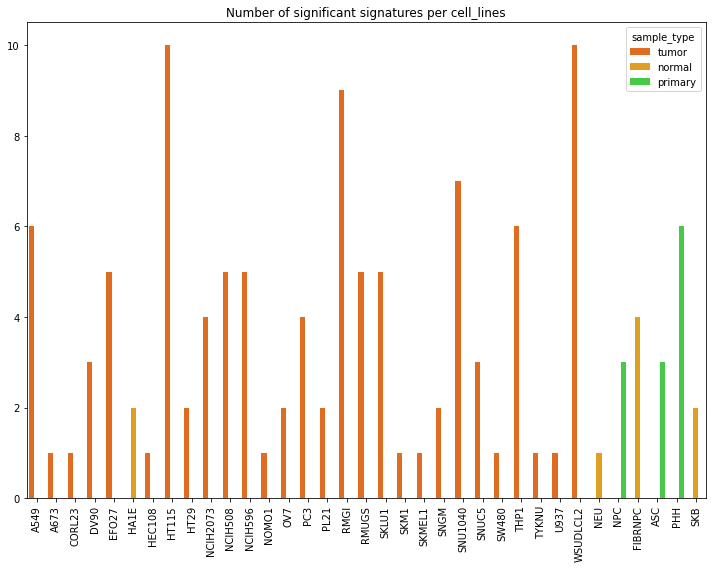

In [159]:
fig, ax = plt.subplots(figsize=(10, 8))

sns.barplot(data=sign_cell_information, x="cell_id", y="count",orient='v',hue = "sample_type").set_title('Number of significant signatures per cell_lines')
plt.xticks(rotation=90)
#sns.despine(top=False, bottom=True)
#ax.bar_label(ax.containers[0])
plt.xlabel("")
plt.ylabel("")
#ax.legend(loc=(0.6,0), title='', fontsize=12)
plt.tight_layout()
#plt.savefig("tamoxifen_significant_signatures.svg")
plt.show()

In [32]:
df_all = pd.concat(overlap_genes,ignore_index=True)

In [36]:
df_all[df_all["gene_symbol"]=="AK4"]

perturbagen_name                                    Signature_id  \
57876        tamoxifen  CPC006_NCIH596_6H:BRD-K93754473-001-06-0:28.39   
57895        tamoxifen  CPC006_NCIH596_6H:BRD-K93754473-001-06-0:28.39   
57935        tamoxifen  CPC006_NCIH596_6H:BRD-K93754473-001-06-0:28.39   
57969        tamoxifen  CPC006_NCIH596_6H:BRD-K93754473-001-06-0:28.39   
58038        tamoxifen  CPC006_NCIH596_6H:BRD-K93754473-001-06-0:28.39   
58060        tamoxifen  CPC006_NCIH596_6H:BRD-K93754473-001-06-0:28.39   
58082        tamoxifen  CPC006_NCIH596_6H:BRD-K93754473-001-06-0:28.39   
58121        tamoxifen  CPC006_NCIH596_6H:BRD-K93754473-001-06-0:28.39   
58144        tamoxifen  CPC006_NCIH596_6H:BRD-K93754473-001-06-0:28.39   
58165        tamoxifen  CPC006_NCIH596_6H:BRD-K93754473-001-06-0:28.39   
58190        tamoxifen  CPC006_NCIH596_6H:BRD-K93754473-001-06-0:28.39   
58213        tamoxifen  CPC006_NCIH596_6H:BRD-K93754473-001-06-0:28.39   
58232        tamoxifen  CPC006_NCIH596_6H:BRD-K93754473-001-06-0:28.39   
58256        tamoxifen  CPC006_NCIH596_6H:BRD-K93754473-001-06-0:28.39   
58282        tamoxifen  CPC006_NCIH596_6H:BRD-K93754473-001-06-0:28.39   
58359        tamoxifen  CPC006_NCIH596_6H:BRD-K93754473-001-06-0:28.39   
58402        tamoxifen  CPC006_NCIH596_6H:BRD-K93754473-001-06-0:28.39   
58441        tamoxifen  CPC006_NCIH596_6H:BRD-K93754473-001-06-0:28.39   
58550        tamoxifen  CPC006_NCIH596_6H:BRD-K93754473-001-06-0:28.39   
58574        tamoxifen  CPC006_NCIH596_6H:BRD-K93754473-001-06-0:28.39   
58729        tamoxifen  CPC006_NCIH596_6H:BRD-K93754473-001-06-0:28.39   
74353        tamoxifen            AML001_CD34_6H:BRD-K93754473:13.4584   
74370        tamoxifen            AML001_CD34_6H:BRD-K93754473:13.4584   
74394        tamoxifen            AML001_CD34_6H:BRD-K93754473:13.4584   
74416        tamoxifen            AML001_CD34_6H:BRD-K93754473:13.4584   
74461        tamoxifen            AML001_CD34_6H:BRD-K93754473:13.4584   
74478        tamoxifen            AML001_CD34_6H:BRD-K93754473:13.4584   
74494        tamoxifen            AML001_CD34_6H:BRD-K93754473:13.4584   
74522        tamoxifen            AML001_CD34_6H:BRD-K93754473:13.4584   
74535        tamoxifen            AML001_CD34_6H:BRD-K93754473:13.4584   
74549        tamoxifen            AML001_CD34_6H:BRD-K93754473:13.4584   
74568        tamoxifen            AML001_CD34_6H:BRD-K93754473:13.4584   
74584        tamoxifen            AML001_CD34_6H:BRD-K93754473:13.4584   
74600        tamoxifen            AML001_CD34_6H:BRD-K93754473:13.4584   
74618        tamoxifen            AML001_CD34_6H:BRD-K93754473:13.4584   
74634        tamoxifen            AML001_CD34_6H:BRD-K93754473:13.4584   
74683        tamoxifen            AML001_CD34_6H:BRD-K93754473:13.4584   
74716        tamoxifen            AML001_CD34_6H:BRD-K93754473:13.4584   
74743        tamoxifen            AML001_CD34_6H:BRD-K93754473:13.4584   
74808        tamoxifen            AML001_CD34_6H:BRD-K93754473:13.4584   
74825        tamoxifen            AML001_CD34_6H:BRD-K93754473:13.4584   
74918        tamoxifen            AML001_CD34_6H:BRD-K93754473:13.4584   

      gene_symbol                                 tissue Sex-bias  
57876         AK4                   Adipose_Subcutaneous   Female  
57895         AK4               Adipose_Visceral_Omentum   Female  
57935         AK4                           Artery_Aorta   Female  
57969         AK4                        Artery_Coronary   Female  
58038         AK4                         Brain_Amygdala     Male  
58060         AK4   Brain_Anterior_cingulate_cortex_BA24     Male  
58082         AK4            Brain_Caudate_basal_ganglia     Male  
58121         AK4                           Brain_Cortex     Male  
58144         AK4               Brain_Frontal_Cortex_BA9     Male  
58165         AK4                      Brain_Hippocampus     Male  
58190         AK4                     Brain_Hypothalamus     Male  
58213  

In [35]:
df_all.groupby(["perturbagen_name", "Signature_id", "gene_symbol"])["Sex-bias"].count().reset_index()

perturbagen_name                             Signature_id gene_symbol  \
0           tamoxifen     AML001_CD34_6H:BRD-K93754473:13.4584        AARS   
1           tamoxifen     AML001_CD34_6H:BRD-K93754473:13.4584       ACOX2   
2           tamoxifen     AML001_CD34_6H:BRD-K93754473:13.4584        ACP5   
3           tamoxifen     AML001_CD34_6H:BRD-K93754473:13.4584         AK4   
4           tamoxifen     AML001_CD34_6H:BRD-K93754473:13.4584      AMDHD2   
...               ...                                      ...         ...   
9413        tamoxifen  NMH002_NPC_6H:BRD-K93754473-048-14-5:10       ZFPL1   
9414        tamoxifen  NMH002_NPC_6H:BRD-K93754473-048-14-5:10       ZMYM2   
9415        tamoxifen  NMH002_NPC_6H:BRD-K93754473-048-14-5:10     ZNF280D   
9416        tamoxifen  NMH002_NPC_6H:BRD-K93754473-048-14-5:10      ZNF442   
9417        tamoxifen  NMH002_NPC_6H:BRD-K93754473-048-14-5:10       ZZEF1   

      Sex-bias  
0            3  
1            9  
2           23  
3           21  
4            2  
...        ...  
9413         1  
9414        25  
9415         4  
9416         4  
9417         1  

[9418 rows x 4 columns]

In [188]:
pd.value_counts(df_all["Signature_id"])

Signature_id
CPC006_HCT116_6H:BRD-K93754473-001-06-0:28.39      18219
CPC006_LOVO_6H:BRD-K93754473-001-06-0:28.39        16436
CPC006_JHUEM2_6H:BRD-K93754473-001-06-0:28.39       7948
NMH002_NEU_6H:BRD-K93754473-001-16-9:10             2782
CPC005_A375_24H:BRD-K04210847-001-01-1:10           2317
                                                   ...  
CPC006_HCC15_6H:BRD-K93754473-001-06-0:28.39         108
CPC006_NCIH508_6H:BRD-K93754473-001-06-0:28.39       108
CPC006_NCIH1694_6H:BRD-K93754473-001-06-0:28.39      105
CPC006_T3M10_6H:BRD-K93754473-001-06-0:28.39          81
CPC006_NOMO1_6H:BRD-K93754473-001-06-0:28.39          79
Name: count, Length: 63, dtype: int64

In [196]:
prueba = df_all[df_all["Signature_id"]=="CPC006_HCC15_6H:BRD-K93754473-001-06-0:28.39"]

In [197]:
prueba.drop_duplicates()

perturbagen_name                                  Signature_id  \
14343        tamoxifen  CPC006_HCC15_6H:BRD-K93754473-001-06-0:28.39   
14344        tamoxifen  CPC006_HCC15_6H:BRD-K93754473-001-06-0:28.39   
14345        tamoxifen  CPC006_HCC15_6H:BRD-K93754473-001-06-0:28.39   
14346        tamoxifen  CPC006_HCC15_6H:BRD-K93754473-001-06-0:28.39   
14347        tamoxifen  CPC006_HCC15_6H:BRD-K93754473-001-06-0:28.39   
...                ...                                           ...   
14446        tamoxifen  CPC006_HCC15_6H:BRD-K93754473-001-06-0:28.39   
14447        tamoxifen  CPC006_HCC15_6H:BRD-K93754473-001-06-0:28.39   
14448        tamoxifen  CPC006_HCC15_6H:BRD-K93754473-001-06-0:28.39   
14449        tamoxifen  CPC006_HCC15_6H:BRD-K93754473-001-06-0:28.39   
14450        tamoxifen  CPC006_HCC15_6H:BRD-K93754473-001-06-0:28.39   

      gene_symbol                    tissue  
14343       GDPD5      Adipose_Subcutaneous  
14344       CEBPA  Adipose_Visceral_Omentum  
14345       CEBPA              Artery_Aorta  
14346       SPAG4              Artery_Aorta  
14347       GDPD5              Artery_Aorta  
...           ...                       ...  
14446       TRAP1                   Thyroid  
14447       WASF3                   Thyroid  
14448       GDPD5                   Thyroid  
14449       NFIL3               Whole_Blood  
14450       INTS3               Whole_Blood  

[108 rows x 4 columns]

In [207]:
pru = prueba[["gene_symbol","tissue"]]

In [217]:
tiss_escape = pru["tissue"]
tiss_escape = tiss_escape.drop_duplicates()
tiss_escape = tiss_escape.tolist()

In [218]:
gene_escape = pru["gene_symbol"]
gene_escape = gene_escape.drop_duplicates()
gene_escape = gene_escape.tolist()

In [225]:
disease_escape_matrix = generate(pru,gene_escape,tiss_escape)

In [227]:
disease_escape_matrix.columns = tiss_escape
disease_escape_matrix.index = gene_escape

In [255]:
disease_escape_matrix.to_csv("matriz_tamoxifen_dos.csv")

In [253]:
tr_matrix = disease_escape_matrix.transpose()

In [254]:
tr_matrix.to_csv("matriz_tamoxifen.csv")

In [ ]:
#Repurposing data

DB00675 (DBID: tamoxifen)	Malignant epithelial neoplasm of female breast (CUI: C3163805)	Approved	
DB00675 (DBID: tamoxifen)	Invasive Ductal Breast Carcinoma (CUI: C1134719)	Approved

In [ ]:
## estrategies for repurposing 

In [ ]:
#escape genes

In [166]:
escape_genes = pd.read_excel(("escape_genes_Oliva2020.xlsx"),engine='openpyxl')

In [170]:
escape_sex_bias_tamoxifen = escape_genes.merge(genes_all_tissues, left_on="HUGO_gene_id", right_on="gene_symbol")

In [172]:
escape_sex_bias_tamoxifen

ENSEMBL_gene_id HUGO_gene_id                            Genetype  \
0   ENSG00000229807.10         XIST                             lincRNA   
1   ENSG00000005889.15          ZFX                      protein_coding   
2   ENSG00000198034.10        RPS4X                      protein_coding   
3   ENSG00000006757.11       PNPLA4                      protein_coding   
4   ENSG00000126012.11        KDM5C                      protein_coding   
5   ENSG00000130021.13         PUDP                      protein_coding   
6   ENSG00000169249.12        ZRSR2                      protein_coding   
7   ENSG00000173674.10       EIF1AX                      protein_coding   
8    ENSG00000215301.9        DDX3X                      protein_coding   
9   ENSG00000130741.10       EIF2S3                      protein_coding   
10  ENSG00000186312.10       CA5BP1  transcribed_unprocessed_pseudogene   
11  ENSG00000072501.17        SMC1A                      protein_coding   
12  ENSG00000130985.16         UBA1                      protein_coding   
13  ENSG00000086712.12        TXLNG                      protein_coding   
14  ENSG00000124486.12        USP9X                      protein_coding   
15  ENSG00000102309.12         PIN4                      protein_coding   

    Sum of relative sex predictivity  Avg of relative sex predictivity (*100)  \
0                          27.913224                                63.439145   
1                           0.571802                                 1.681771   
2                           0.437481                                 2.083242   
3                           0.284667                                 1.293940   
4                           0.282845                                 1.131381   
5                           0.244160                                 0.739878   
6                           0.202390                                 1.065212   
7                           0.123401                                 0.822676   
8                           0.033712                                 0.421399   
9                           0.002818                                 0.040263   
10                          0.002784                                 0.069600   
11                          0.001860                                 0.062003   
12                          0.001677                                 0.083839   
13                          0.001319                                 0.032986   
14                          0.000348                                 0.034813   
15                          0.000162                                 0.016223   

    #Tissues predictivity  Female-biased  Male-biased  Female-biased (median)  \
0                    44.0             44            0                   9.514   
1                    34.0             44            0                   0.581   
2                    21.0             44            0                   0.485   
3                    22.0             44            0                   0.419   
4                    25.0             44            0                   0.448   
5                    33.0             44            0                   0.562   
6                    19.0             44            0                   0.419   
7                    15.0             44            0                   0.460   
8                     8.0             44            0                   0.419   
9                     7.0             44            0                   0.288   
10                    4.0             44            0                   0.282   
11                    3.0             44            0                   0.239   
12                    2.0             44            0                   0.168   
13                    4.0             44            0                   0.305   
14                    1.0             44            0                   0.159   
15                    1.0             44            0    

In [ ]:
# 16/17 son escape genes, all have female sex-bias, present female-biased in 44 tissues

In [176]:
escape_sex_bias_tamoxifen_all_genes = escape_genes.merge(df_more_impot_genes, left_on="HUGO_gene_id", right_on="gene_symbol")

In [179]:
escape_genes_filter = escape_sex_bias_tamoxifen_all_genes[escape_sex_bias_tamoxifen_all_genes["Reported Escapee?"]==1]

In [180]:
escape_genes_filter.loc[escape_genes_filter['Male-biased'] > escape_genes_filter['Female-biased'], 'Gene-bias'] = 1 
escape_genes_filter.loc[escape_genes_filter['Male-biased'] < escape_genes_filter['Female-biased'], 'Gene-bias'] = 2
escape_genes_filter.loc[escape_genes_filter['Male-biased'] == escape_genes_filter['Female-biased'], 'Gene-bias'] = 0

In [181]:
escape_genes_filter

ENSEMBL_gene_id HUGO_gene_id        Genetype  \
0    ENSG00000229807.10         XIST         lincRNA   
1    ENSG00000005889.15          ZFX  protein_coding   
2    ENSG00000198034.10        RPS4X  protein_coding   
3    ENSG00000006757.11       PNPLA4  protein_coding   
4    ENSG00000126012.11        KDM5C  protein_coding   
..                  ...          ...             ...   
241   ENSG00000186310.9       NAP1L3  protein_coding   
243   ENSG00000189221.9         MAOA  protein_coding   
244  ENSG00000089820.15      ARHGAP4  protein_coding   
246  ENSG00000102178.12        UBL4A  protein_coding   
248  ENSG00000189108.12     IL1RAPL2  protein_coding   

     Sum of relative sex predictivity  \
0                           27.913224   
1                            0.571802   
2                            0.437481   
3                            0.284667   
4                            0.282845   
..                                ...   
241                               NaN   
243                               NaN   
244                               NaN   
246                               NaN   
248                               NaN   

     Avg of relative sex predictivity (*100)  #Tissues predictivity  \
0                                  63.439145                   44.0   
1                                   1.681771                   34.0   
2                                   2.083242                   21.0   
3                                   1.293940                   22.0   
4                                   1.131381                   25.0   
..                                       ...                    ...   
241                                      NaN                    NaN   
243                                      NaN                    NaN   
244                                      NaN                    NaN   
246                                      NaN                    NaN   
248                                      NaN                    NaN   

     Female-biased  Male-biased  Female-biased (median)  Male-biased (median)  \
0               44            0                   9.514                   NaN   
1               44            0                   0.581                   NaN   
2               44            0                   0.485                   NaN   
3               44            0                   0.419                   NaN   
4               44            0                   0.448                   NaN   
..             ...          ...                     ...                   ...   
241             26            0                   0.105                   NaN   
243              1            2                   0.049                -0.070   
244              0            2                     NaN                -0.030   
246              1           18                   0.065                -0.021   
248              1            0                   0.381                   NaN   

     Reported Escapee? gene_symbol  perturbagen_name  tissue  Gene-bias  
0                    1        XIST                44      44        2.0  
1                    1         ZFX                44      44        2.0  
2                    1       RPS4X                44      44        2.0  
3                    1      PNPLA4                44      44        2.0  
4                    1       KDM5C                44      44        2.0  
..                 ...         ...               ...     ...        ...  
241                  1      NAP1L3                26      26        2.0  
243                  1        MAOA                 3       3        1.0  
244                  1     ARHGAP4                 2       2        1.0  
246                  1       UBL4A                19      19        1.0  
248                  1    IL1RAPL2                 1       1        2.0  

[161 rows x 15 columns]

In [182]:
pd.value_counts(escape_genes_filter["Gene-bias"])

Gene-bias
2.0    99
1.0    56
0.0     6
Name: count, dtype: int64

In [ ]:
## 161/5070 escape genes, more female-biased 